# Projet Optimisation

## DRALET Florent et MISME Raphaël

## PARTIE 1 : Présentation du problème étudié et de la base de données

Source principale : 
Aaboe, S., Down, E.J., Sørensen, A., Lavergne, T., Eastwood, S. (2023).
Sea Ice Edge and Sea Ice Type Climate Data Records, Version 3.0: Product User Guide and Specification. Copernicus Climate Change Service. Document ref. WP2-FDDP-2022-09_C3S2-Lot3_PUGS-of
v3.0-SeaIceEdgeType-products_v3.1.

La présence ou l'absence de Glace de Mer influe sur le rayonnement émis par la Terre (Albedo) et sur les interactions Océan-Atmosphère. Son évolution temporelle est un indicateur du dérèglement climatique. Pour ces raisons, il est nécessaire de pouvoir déterminer l'évolution et le type de glace de mer présent dans la région Arctique.

Pour déterminer le type de glace de mer présent dans une zone donnée, les climatologues utilisent des mesures provenant de différents radiomètres micro-ondes sur différentes fréquences et pour différentes polarisations (voir figures ci-dessous).

![Radiomètres Embarquées](Images%20Projet/Radiomètres%20Embarquées.png)

![Bandes de Fréquence](Images%20Projet/Bandes%20de%20Fréquence.png)

La concentration en glace de mer (SICO) d'une surface est la proportion de cette surface qui est recouverte de glace de mer. 
Les climatologues considère qu'une SICO en dessous de 30% correspond à l'absence de glace de mer.

Il existe alors 3 types de glace de mer (SICO>30%) :
- La glace de mer pluriannuelle (MYI) : Glace ancienne ayant survécu à au moins une saison de fonte.
- La glace de mer saisonnière ou de première année (FYI) : Glace qui s'est formée uniquement depuis la dernière saison de fonte.
- Le type de glace de mer ambigu (AMB) : Glace dont le type est ambigu (probabilité trop faible donné par le procédé de classification) 

Cette classification n'est réalisée que pour l'Arctique uniquement pour la période entre Avril et Octobre (en raison de la fonte de la surface en période estivale qui rend la méthode de classification inopérante).

Le jeu de données utilisé repose sur la radiométrie micro-ondes, une technique permettant de distinguer les types de glace de mer en fonction de leurs propriétés physiques (salinité, densité, rugosité de surface). Le passage des données brutes au produit final suit un protocole défini. Les deux étapes importantes sont :

Correction atmosphérique : Les températures de brillance ($T_B$) sont corrigées via un modèle de transfert radiatif (RTM) utilisant des données de réanalyse (vent, température, humidité) pour éliminer les perturbations liées à l'atmosphère.

Classification : Les types de glace sont classés à l'aide de calculs de probabilité bayésienne.

La zone Arctique est découpée en pixels de 25km x 25km (grille de 275 x 205 points). Dans le dataset utilisé dans la suite, nous avons le type de glace (SIT) pour la journée du 31 Janvier 2015 et pour chacun des pixels. En plus du SIT, le dataset présente pour chacun des pixels la température de brillance (en K) pour 6 canaux micro-onde de fréquence (06,10,18,23,36,89)GHz et pour 2 polarisations (H et V) mesurée par le radiomètre AMSR2.

- Classe 1 Absence de glace de mer 
- Classe 2 Glace de mer saisonnière (qui n’est pas présente toute l’année) 
- Classe 3 Glace de mer pluriannuelle (qui reste toute l’année) 
- Classe 4 Glace de mer de type inconnu 

L'objectif de notre projet est de construire un classifieur SVM destiné à retrouver le type de glace de mer présente sur chaque pixel de la zone Arctique en fonction des 12 Températures de Brillance évoquées précédemment (sans réaliser le protocole complexe décrit plus haut).

In [1]:
import pandas as pd              
import numpy as np               
import matplotlib.pyplot as plt  
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim

import time

path='C:/Users/flodr/Desktop/Florent/ENS/A3 (M2 MOCIS)/DATA2 IA'

In [2]:
ds_original=xr.open_dataset(path+"/AMSR2_SIT_31012015.nc")

In [3]:
ds_original

<xarray.Dataset>
Dimensions:  (xc: 275, yc: 205)
Coordinates:
    lon      (xc, yc) float32 ...
    lat      (xc, yc) float32 ...
Dimensions without coordinates: xc, yc
Data variables: (12/13)
    sit      (xc, yc) float32 ...
    v06      (xc, yc) float64 ...
    h06      (xc, yc) float64 ...
    v89      (xc, yc) float64 ...
    h89      (xc, yc) float64 ...
    h36      (xc, yc) float64 ...
    ...       ...
    h23      (xc, yc) float64 ...
    v23      (xc, yc) float64 ...
    h18      (xc, yc) float64 ...
    v18      (xc, yc) float64 ...
    h10      (xc, yc) float64 ...
    v10      (xc, yc) float64 ...
Attributes:
    description:  Sea Ice Type 2015 Jan 31st

In [4]:
print(np.unique(ds_original['sit'].values))

[ 1.  2.  3.  4. nan]


## PARTIE 2 : Les fonctions de coût à considérer

**<u>Partie 1 : Problème dual avec ou sans noyau**

Type de problème : Problème quadratique, convexe, contraint.
$$\max_{\lambda} \Theta(\lambda) = \sum_{i=1}^{u} \lambda_i - \frac{1}{2} \sum_{i,j=1}^{u} \lambda_i \lambda_j y_i y_j 
\begin{cases} 
K(x_i, x_j) & \text{avec noyau} \\ 
x_i^T x_j & \text{sans noyau} 
\end{cases}$$
Sous les contraintes :
    
$\sum_{i=1}^{u} \lambda_i y_i = 0$   
$\forall i, \quad 0 \le \lambda_i \le C$

Algorithmes de résolution : 
- Algorithme SMO (Sequential Minimal Optimization)
  
\
\
\
**<u>Partie 2 : Problème primal avec Hinge Loss**

Type de problème : Problème convexe, non contraint, non lisse.
$$\min_{w,b} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{u} \max(0, 1 - y_i(w^T x_i + b))$$
Algorithmes de résolution :
- Chambolle-Pock
- Adam (Adaptive Moment Estimation)

In [5]:
#Fonction Loss Primal qui servira à calculer une évolution de la Loss unifiée pour les 3 algorithmes
def fonction_loss(X_train, Y_train, w, b):
    return 0.5 * np.sum(w ** 2) + 1.0 * np.sum(np.maximum(0, 1 - Y_train * (X_train @ w + b)))

## PARTIE 3 : Le détail des algorithmes et leur implémentation

### 3.1 L'algorithme SMO (Sequential Minimal Optimization) 

Sources principales :
- Platt, John. (1999). Fast Training of Support Vector Machines Using Sequential Minimal Optimization. Advances in Kernel Methods: Support Vector Learning. 185-208. 
- CS 229, Autumn 2009 The Simplified SMO Algorithm. https://cs229.stanford.edu/materials/smo.pdf

Pour ne pas rendre l'explication trop longue, tous les calculs ne seront pas présentés sur ce notebook, pour obtenir le détail calculatoire, se référer aux 2 sources énoncées ci-dessus.

### A. Introduction

L'algorithme SMO est conçu pour résoudre efficacement le problème d'optimisation quadratique posé par les Machines à Vecteurs de Support (SVM). Rappelons la formulation mathématique du problème.

1. Le Problème Primal des SVM à marge souple (Soft Margin)

Pour gérer les données qui ne sont pas parfaitement linéairement séparables, on introduit des variables d'écart $\xi_i$ (slack variables). Le problème consiste à minimiser :
$$\min_{w, b, \xi} \frac{1}{2} \|w\|^2 + C \sum_{i} \xi_i$$

Sous les contraintes :

$\xi_i \geq 0$ : Pénalité pour les points situés à l'intérieur de la marge ou mal classés.

$y_i (\langle w, x_i \rangle + b) \geq 1 - \xi_i$ : Les points sont "bien classés" (à une pénalité $\xi_i$ près).

Interprétation : $\frac{1}{2} \|w\|^2$ correspond à la maximisation de la marge.
$C$ est le paramètre de régularisation qui contrôle le compromis entre la largeur de la marge et l'erreur de classification.

2. Passage au Problème Dual

En utilisant les multiplicateurs de Lagrange, on transforme le problème primal en un problème dual, qui est souvent plus simple à résoudre (notamment pour l'utilisation de fonctions noyaux $K$).
On cherche à maximiser la fonction $\Theta(\lambda)$ :
$$\max_{\lambda} \Theta(\lambda) = \sum_{i=1}^{m} \lambda_i - \frac{1}{2} \sum_{i,j=1}^{m} \lambda_i \lambda_j y_i y_j K(x_i, x_j)$$

Les conditions sous lesquels on minimise $\Theta(\lambda)$ sont décrire ci-dessus.

3. Les Conditions KKT (Karush-Kuhn-Tucker)

Dans le cadre des SVM, on définit :
- La fonction de décision $f(x_i)$ : C'est la classe prédite par le modèle {+1,-1} pour une entrée $x_i$.
$$f(x_i) = \sum_{j=1}^{m} \lambda_j y_j K(x_j, x_i) + b$$

- L'erreur de prédiction $E_i$ : C'est la différence entre la prédiction du modèle et la "vérité".
$$E_i = f(x_i) - y_i$$


Le fonctionnement de l'algorithme SMO repose sur la vérification des conditions de Karush-Kuhn-Tucker (KKT). À l'optimum, ces conditions doivent être satisfaites (réécriture des conditions KKT):

$$\begin{cases} 
\lambda_i = 0 & \implies y_i E_i \geq 1 & \text{(Point bien classé)} \\ 
0 < \lambda_i < C & \implies y_i E_i = 1 & \text{(Vecteur de support sur la marge)} \\ 
\lambda_i = C & \implies y_i E_i \leq 1 & \text{(Point entre les marges ou mal classé)} 
\end{cases}$$

### B. Principe de fonctionnement de l'algorithme

L'idée centrale de l'algorithme SMO est de décomposer le problème global en sous-problèmes plus simples. D'après la contrainte d'égalité $\sum \lambda_i y_i = 0$, on ne peut pas modifier un seul multiplicateur $\lambda_i$ sans violer cette contrainte. Le plus petit changement possible implique donc le changement de deux multiplicateurs simultanément.

L'objectif est d'optimiser deux multiplicateurs, $\lambda_i$ et $\lambda_j$, en considérant que tous les autres sont fixes (constants).À partir de la contrainte globale :$$\sum_{i=1}^{m} \lambda_i y_i = 0$$On peut isoler les deux multiplicateurs choisis :$$\lambda_i y_i + \lambda_j y_j = -\sum_{k \neq i,j} \lambda_k y_k = \text{Constante}$$

Cela nous permet d'exprimer $\lambda_i$ directement en fonction de $\lambda_j$ :$$\lambda_i = \frac{\text{Constante} - \lambda_j y_j}{y_i}$$En remplaçant $\lambda_i$ par cette expression dans la fonction objectif $\Theta(\lambda)$, celle-ci ne dépend plus que d'une seule variable : $\lambda_j$ (expression non détaillée ici).

L'intérêt majeur de cette approche est de transformer un problème d'optimisation complexe en une simple optimisation quadratique unidimensionnelle.Puisque $\Theta(\lambda)$ devient une fonction quadratique de $\lambda_j$, on peut alors trouver la valeur optimale de $\lambda_j$ analytiquement (point d'annulation de la dérivée).

La contrainte linéaire ($\lambda_i y_i + \lambda_j y_j = \text{Constante}$) et les contraintes de "boîte" ($0 \leq \lambda \leq C$) définissent un segment $[L, H]$ (calcul non détaillé ici) sur lequel $\lambda_j$ doit se situer. Il suffit de calculer la nouvelle valeur pour $\lambda_j$ donnée analytiquement, puis de la "clipper"="projeter" pour qu'elle reste dans cet intervalle $[L, H]$.

Enfin on calcule la nouvelle valeur pour $\lambda_i$ d'après la relation le liant à $\lambda_j$ (contrainte linéaire)

On réalise une succession de modifications par paires de multiplicateurs de Lagrange tant qu'il existe des points qui ne vérifient pas les conditions KKT (à une tolérance près). 

### C. Détails de l'algorithme

<u>1. La sélection des 2 multiplicateurs de Lagrange à optimiser

On initialise tous les multiplicateurs de Lagrange à 0.

L'algorithme parcourt les données jusqu'à trouver un point qui ne respecte pas les conditions KKT énoncées précédemment, son indice est $i$.

Ensuite, on cherche un deuxième indice $j$ tel que $0 < \lambda_j < C$. En faisant cela, on a beaucoup plus de chances de trouver une direction d'optimisation qui ne va pas immédiatement "taper" contre une borne ($0$ ou $C$) lors du clipping.
Dans l'ensemble des indices vérifiant l'inégalité ('valid_indices' dans le code) on cherche l'indice $j$ qui maximise $|E[i]-E[j]|$. En faisant cela, on s'assure de pouvoir faire un grand "pas de progression". 

Dans le cas où il n'y a aucun points vérifiant $0 < \lambda_j < C$ (par exemple au premier tour de boucle), $j$ est choisi aléatoirement différent de $i$.


<u>2. Calcul de la nouvelle valeur de $\lambda_j$ non clipped

- Calcul de $\eta$, il correspond à l'opposée de la norme au carré de la différence des vecteurs dans l'espace des features (Espace de Hilbert) ($\eta = -\|\phi(x_i) - \phi(x_j)\|^2$):
$$\eta = 2K(x_i, x_j) - K(x_i, x_i) - K(x_j, x_j)$$

Puisqu'une norme au carré est toujours positive ou nulle, $\eta$ doit être négatif. Si $\eta \geq 0$, cela signifie que les points sont identiques ou que le noyau ne permet pas d'optimiser ce couple, d'où le 'continue' dans le code.

- La nouvelle valeur du multiplicateur de Lagrange $\lambda_j$ est calculée en trouvant le sommet de la parabole de la fonction objectif (point d'annulation de la dérivée) :
$$\lambda_j^{new} = \lambda_j^{old} - \frac{y_j(E_i - E_j)}{\eta}$$
    
<u>3. Calcul des bornes $L$ et $H$,  "clipping" et mise à jour de $\lambda_j$ et $\lambda_i$
    
L'optimisation simultanée de deux multiplicateurs $\lambda_i$ et $\lambda_j$ doit respecter le système suivant :$$\begin{cases} 
0 \leq \lambda_i, \lambda_j \leq C & \text{(Contraintes de boîte)} \\
y_i \lambda_i + y_j \lambda_j = \text{constante} & \text{(Contrainte linéaire d'égalité)} 
\end{cases}$$
    
- Selon que les étiquettes $y_i$ et $y_j$ sont identiques ou opposées, la contrainte linéaire définit un segment de droite différent dans la "boîte" $[0, C] \times [0, C]$. Les bornes $L$ (basse) et $H$ (haute) pour $\lambda_j$ sont alors :
    
    Cas $y_i \neq y_j$ (Classes différentes) :
    
    La contrainte linéaire est $\lambda_j - \lambda_i = constante$.
    $$\begin{cases}
L = \max(0, \lambda_j^{old} - \lambda_i^{old}) \\
H = \min(C, C + \lambda_j^{old} - \lambda_i^{old})
\end{cases}$$
    
    
    Cas $y_i = y_j$ (Classes similaires) :
    
    La contrainte est $\lambda_j + \lambda_i = constante$.
    $$\begin{cases}
L = \max(0, \lambda_j^{old} + \lambda_i^{old} - C) \\
H = \min(C, \lambda_j^{old} + \lambda_i^{old})
\end{cases}$$
    
    
-On projette $\lambda_j^{new}$ dans l'intervalle $[L, H]$ pour garantir le respect de la contrainte de boîte :$$\lambda_j^{new, \text{clipped}} = 
\begin{cases} 
H & \text{si } \lambda_j^{new} > H \\
\lambda_j^{new} & \text{si } L \leq \lambda_j^{new} \leq H \\
L & \text{si } \lambda_j^{new} < L 
\end{cases}$$
    
- En raison de la contrainte de somme $\sum y_i \lambda_i = 0$, toute modification de $\lambda_j$ doit être compensée par une modification de $\lambda_i$ pour maintenir l'égalité. La relation de mise à jour pour $\lambda_i$ est :$$\lambda_i^{new} = \lambda_i^{old} + y_i y_j (\lambda_j^{old} - \lambda_j^{new, \text{clipped}})$$
    
Cette formule garantie que $\lambda_i^{new}$ sera lui aussi dans l'intervalle $[0,C]$
    
<u>4. Mise à jour du paramètre $b$
    
Dans cet algorithme d'implémentation, nous avons besoin de calculer l'erreur de prédiction $E_i$ pour chacun des points de données (pour le choix du deuxième multiplicateur de Lagrange notamment). Or pour calculer $E_i$ nous avons besoin de calculer la prédiction $f(x_i)=\sum_{j=1}^{m} \lambda_j y_j K(x_j, x_i) + b$. Cette expression montre que nous avons besoin de mettre à jour la valeur de $b$ malgré le passage dans le dual.
    
    
On calcule deux valeurs potentielles pour le nouveau biais. $b_1$ est la valeur qui forcerait le point $i$ à être exactement sur la marge, tandis que $b_2$ fait de même pour le point $j$.
    
Les formules sont les suivantes :
    $$b_1 = b - E_i - y_i(\lambda_i^{new} - \lambda_i^{old})K(x_i, x_i) - y_j(\lambda_j^{new} - \lambda_j^{old})K(x_i, x_j)$$
    $$b_2 = b - E_j - y_i(\lambda_i^{new} - \lambda_i^{old})K(x_i, x_j) - y_j(\lambda_j^{new} - \lambda_j^{old})K(x_j, x_j)$$
    
Le choix de la valeur finale $b^{new}$ dépend du statut des multiplicateurs de Lagrange (s'ils sont "libres" ou "bornés") :
    
- Cas 1 : Si $0 < \lambda_i^{new} < C$, alors le point $i$ est un vecteur de support "libre" situé sur la marge. Dans ce cas, $b_1$ est la valeur correcte à choisir pour $b$ :$$b^{new} = b_1$$
    
- Cas 2 : Sinon, si $0 < \lambda_j^{new} < C$, le point $j$ est un vecteur de support "libre". On choisit alors :$$b^{new} = b_2$$
    
- Cas 3 : Si aucun des deux n'est un vecteur de support libre (ils sont tous deux à $0$ ou $C$), n'importe quelle valeur entre $b_1$ et $b_2$ satisfait les conditions KKT. On utilise généralement la moyenne :$$b^{new} = \frac{b_1 + b_2}{2}$$
    
(Si les cas 1 et 2 sont vérifiés simultanément, c'est-à-dire, si les points d'indice i et j sont tous les deux vecteurs de support libres après la mise à jour, alors on a $b_1=b_2=b^{new}$.)
    
<u>5. Mise à jour du cache pour $E$
    
Pour rendre l'algorithme SMO efficace, on ne recalcule pas $E_i$ pour chaque point de données car ce calcul implique le calcul de $f(x_i)=\sum_{j=1}^{m} \lambda_j y_j K(x_j, x_i) + b$ qui contient une somme sur le nombre de donnée (dans notre cas $m\simeq25000$). On utilise au lieu de ça une formule qui calcule directement la variation de $E_i$ pour tous les points en fonction de la variation de $\lambda_i$, de $\lambda_j$ et de $b$ :
$$E_k^{new} = E_k^{old} + (y_i \Delta \lambda_i) K_{i,k} + (y_j \Delta \lambda_j) K_{j,k} + \Delta b$$
    
où l'on note $K$ la Matrice de Gram définie par : 
$$K_{ij}=K(x_i, x_j)$$
    
Si l'on utilise pas de noyau (X la matrice des données) :
$$K=XX^T$$
    
Par ailleurs, d'après les conditions KKT, tout vecteur de support libre (non égal à 0 ou C) doit se situer exactement sur la marge :$$\text{Si } 0 < \lambda_i < C, \text{ alors } y_i f(x_i) = 1 \implies f(x_i) = y_i \implies E_i = 0$$L'étape (c) force cette valeur à zéro (pour éviter les approximations numériques).
    
    
<u>6. Condition d'arrêt
    
- On parcourt à chaque tour de boucle toutes les données "for i in range(0,m)"
- Si la donnée i ne respecte pas KKT on commence le processus d'optimisation, sinon on passe à la donnée suivante
- Si finalement, le processus d'optimisation a abouti à une modification de $\lambda_i$ et $\lambda_j$, 'num_changed_lambda' initialisé à 0, augmente de 1
- Si en parcourant toutes les données de 0 à m-1 on n'a réalisé aucune modification, 'passes' initialement à 0 est augmenté de 1, dans le cas contraire elle est réinitialisé à 0. Si on a réalisé aucune modification, cela signifie généralement que tous les points vérifient les conditions KKT à une tolérance (tol) près.
- Si passes dépasse max_passes, dans notre cas si on a parcouru 10 fois les données d'affilé sans rien changer, alors on arrête l'algorithme
    
Le fait de ne pas simplement arrêter l'algorithme lorsque l'on change aucun lambda lors d'un tour des données provient du fait que le deuxième indice $j$ peut-être choisi aléatoirement, c'est donc une 'sécurité' pour l'algorithme. Mais dans les faits, on a observé que dès que l'on parcourait toutes les données sans rien changé, cela perdurait pour les tours de boucle suivants.

In [59]:
#Définition de la Matrice de Gram associée au cas sans noyau
def Matrice_Gram_Linéaire_Calc(X):
    return X @ X.T


def Matrice_Gram_NoyauGaussien_Calc(X,sigma):
    
    X = X.astype(np.float32)
    
    gamma = 1 / (2 * sigma**2)
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    Matrice_Gram_NoyauGaussien = np.exp(-gamma * (X_norm + X_norm.T - 2 * (X @ X.T)))
    
    return Matrice_Gram_NoyauGaussien

In [111]:
def SMO(X_train, Y_train):
    
    
    #################################
    #Les paramètres de l'algorithme SMO
    C = 1.
    tol = 0.01
    delta_significatif = 10 ** (-5)
    max_passes = 10
    #################################
    
    #Choix du Noyau
    start = time.perf_counter()
    Matrice_Gram = Matrice_Gram_Linéaire_Calc(X_train) #Cas linéaire
    #Matrice_Gram = Matrice_Gram_NoyauGaussien_Calc(X_train,sigma=5) #Cas Noyau Gaussien
    end = time.perf_counter()
    
    Temps_calc_Matrice_Gram = end - start
    
    #Initialisation
    idx_time=0
    m = len(Y_train)
    Vect_Lambda = np.zeros(m)
    b = 0
    E_cache = -Y_train.astype(float).copy()
    passes = 0
    Tab_Loss = []
    Tab_Time = []
    Tab_Time.append(Temps_calc_Matrice_Gram)
    w=(Vect_Lambda * Y_train) @ X_train
    Tab_Loss.append(fonction_loss(X_train, Y_train, w, b))
    
    #Condition d'arrêt : sur (max_passes) couples (i,j) d'affilé, on n'a pas changé les lambdas
    while passes < max_passes:
        
        start = time.perf_counter()
        
        num_changed_lambda = 0
        
       ############################################################
       #1. Sélection des 2 multiplicateurs de Lagrange à optimiser#
       ############################################################
    
        #On parcourt les m données
        for i in range(0, m):
            E_i = E_cache[i]
            
            #On prend la première donnée i qui ne respecte pas les conditions KKT
            if (Y_train[i] * E_i < -tol and Vect_Lambda[i] < C) or (Y_train[i] * E_i > tol and Vect_Lambda[i] > 0):
                
                #On choisi une deuxième donnée j qui maximise abs(E_i-E_j)
                valid_indices = np.where((Vect_Lambda > 0) & (Vect_Lambda < C))[0]
        
                j = -1 # Valeur par défaut si on ne trouve personne
        
                #Application de l'heuristique s'il y a des candidats
                if len(valid_indices) > 0:
        
                    # On extrait les erreurs correspondant aux candidats
                    candidate_errors = E_cache[valid_indices]
            
                    if E_i > 0:
                        # On cherche le E_j minimum
                        min_index_local = np.argmin(candidate_errors)
                        j = valid_indices[min_index_local]
            
                    else:
                        # On cherche le E_j maximum
                        max_index_local = np.argmax(candidate_errors)
                        j = valid_indices[max_index_local]
            
                
                # Plan de secours si la liste des candidats était vide, on sélectionne j!=i aléatoirement
                if j == -1 or j == i:
                    j = i
                    while j == i:
                        j = np.random.randint(0, m)
            
                E_j = E_cache[j]
                
                #On récupère les valeurs des deux multiplicateurs de Lagrange avant modification
                lambda_i_old, lambda_j_old = Vect_Lambda[i], Vect_Lambda[j]
        
                #############################################
                #2. Calcul de la nouvelle valeur de lambda_j#
                #############################################
                
                #Correspond à l'inverse d'une norme au carré. Si c'est nul, on ne peut pas faire de division par 0 et on laisse
                #tomber le couple (i,j) sélectionné (continue)
                eta = 2 * Matrice_Gram[i,j] - Matrice_Gram[i,i] - Matrice_Gram[j,j]
                if eta >= 0 :
                    continue
                
                #Mise à jour de lambda_j par maximisation du Lagrangien par rapport aux multiplicateurs de Lagrange
                lambda_j_new = lambda_j_old - (Y_train[j] * (E_i - E_j) / eta)
                
                #################################################################################
                #3. Calcul des bornes L et H, "clipping", et mise à jour de lamdba_j et lambda_i#
                #################################################################################
                
                #Calcul de L et H pour l'étape de clipping. 
                #On a une disjonction de cas si les points sont de classe différente ou pas.
            
                #Cas (i,j) Classe Différente
                if Y_train[i] != Y_train[j]:
                    L = max(0, lambda_j_old - lambda_i_old)
                    H=min(C, C + lambda_j_old - lambda_i_old)
            
                #Cas (i,j) Classe Similaire
                if Y_train[i] == Y_train[j]:
                    L = max(0, lambda_j_old + lambda_i_old-C)
                    H = min(C, lambda_j_old + lambda_i_old)
            
                #L et H sont les bornes pour la nouvelle valeur possible de lambda_j
                #Si L=H alors lambda_i ne bouge pas et sa valeur reste égale à la seule possible, lambda_j_old
                if L == H : 
                    continue
            
                #Opération de clipping avec les bornes L et H
                if lambda_j_new > H:
                    lambda_j_new = H
                elif lambda_j_new < L:
                    lambda_j_new = L
            
                #Si le changement sur lambda_j n'est pas significatif on le laisse tomber
                if abs(lambda_j_new - lambda_j_old) < delta_significatif:
                    continue
        
                #Mise à jour de lamdba_i d'après la valeur trouvée pour lambda_j
                lambda_i_new = lambda_i_old + Y_train[j] * Y_train[i] * (lambda_j_old - lambda_j_new)
            
                #####################
                #4. Mise à jour de b#
                #####################
                
                #On calcule b_1, le b qui forcerait la donnée i à être sur la marge
                b_1 = (b - E_i - Y_train[i] * (lambda_i_new - lambda_i_old) * Matrice_Gram[i,i] 
                - Y_train[j] * (lambda_j_new-lambda_j_old) * Matrice_Gram[i,j])
                #On calcule b_2, le b qui forcerait la donnée j à être sur la marge
                b_2 = (b - E_j - Y_train[i] * (lambda_i_new - lambda_i_old) * Matrice_Gram[i,j] 
                - Y_train[j] * (lambda_j_new - lambda_j_old) * Matrice_Gram[j,j])
        
                #Si la donnée i est vecteur de support, on choisi son b_1
                if lambda_i_new > 0 and lambda_i_new < C:
                    b_new = b_1
                #Si la donnée j est vecteur de support, on choisi son b_2
                elif lambda_j_new > 0 and lambda_j_new < C:
                    b_new = b_2
                #Si aucun n'est vecteur de support après la mise à jour on prend une moyenne des 2
                else : b_new = (b_1 + b_2) / 2
                
                #####################################################
                #5. Mise à jour du cache qui stocke les valeurs de E#
                #####################################################
                
                #Calcul des variations pour la mise à jour du cache
                delta_lambda_i = lambda_i_new - lambda_i_old
                delta_lambda_j = lambda_j_new - lambda_j_old
                delta_b = b_new - b
        
                #Mise à jour des deux lambda et de b
                Vect_Lambda[i] = lambda_i_new
                Vect_Lambda[j] = lambda_j_new
                b = b_new

                ## Mise à jour du cache pour E pour tous les points de données
                # a. On récupère le lignes correspondant aux indices i et j de la Matrice de Gram
                Ki = Matrice_Gram[i, :] # Toute la ligne i
                Kj = Matrice_Gram[j, :] # Toute la ligne j
            
                # b. On applique la formule vectorielle de modification de E_i pour tous les points de données en même temps
                #E_new = E_old + delta_ai * yi * Ki + delta_aj * yj * Kj + delta_b
                E_cache = E_cache + (delta_lambda_i * Y_train[i] * Ki + delta_lambda_j * Y_train[j] * Kj + delta_b)

                # c. Force la remise à zéro pour i et j (sécurité numérique)
                # Uniquement si ils sont strictement entre 0 et C (Vecteurs de support)
                if 0 < Vect_Lambda[i] < C:
                    E_cache[i] = 0
                if 0 < Vect_Lambda[j] < C:
                    E_cache[j] = 0
            
                #Compteur de changement effectué lors d'un tour de boucle de toutes les données
                num_changed_lambda += 1
                
            
        #Compteur du nombre de fois où aucun changement n'a été effectué dans tout le tour de boucle, d'affilé.
        if num_changed_lambda == 0:
            passes += 1
        else :
            passes = 0
            
        end = time.perf_counter()
                
        #Calcul du temps mis pour réalisé l'itérartion pour évaluation de l'algorithme
        Tab_Time.append(end - start + Tab_Time[-1])
                
        idx_time+=1
                
        #Calcul de la Loss pour évaluation de l'algorithme
        #Les conditions KKT nous donnent à l'optimum une expression de w en fonction des lambda, de X_train et Y_train
        w=(Vect_Lambda * Y_train) @ X_train
        Tab_Loss.append(fonction_loss(X_train, Y_train, w, b))
            
    Tab_Loss = np.array([Tab_Time, Tab_Loss])
    
    return(Vect_Lambda, b, Tab_Loss)

### 3.2 L'algorithme Chambolle-Pock

Source principale :

Wikipédia : https://en.wikipedia.org/wiki/Chambolle%E2%80%93Pock_algorithm

### A. Introduction

On souhaite résoudre le problème d'optimisation convexe, non contraint et non lisse suivant (cas d'un SVM à marge souple) :
$$\min_{w, b} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i(w^T x_i + b))$$

Dans la suite on renommera les données $(x_i, y_i)$ en $(\alpha_i, \beta_i)$ afin d'éviter la confusion avec la variable primale $x$ et la variable duale $y$.

L'algorithme de Chambolle-Pock est conçu pour résoudre des problèmes d'optimisation de la forme générale :
$$\min_{x} G(x) + F(Kx)$$

Où :
- $x$ : la variable à optimiser.
- $G$ : une fonction convexe et lisse.
- $F$ : une fonction convexe, potentiellement non lisse.
- $K$ : un opérateur linéaire.

Dans notre cas précis, on a :

La variable d'état :
$$x = \begin{pmatrix} w \\ b \end{pmatrix}$$

La fonction lisse :
$$G(x) = \frac{1}{2} \|w\|^2$$

L'opérateur linéaire :
On définit l'opérateur $K$ tel que pour chaque échantillon $i$ :$$(Kx)_i = \beta_i(w^T \alpha_i + b) = \beta_i \alpha_i^T w + \beta_i b$$
Sous forme matricielle :
$$Kx = \begin{pmatrix} \beta_1(w^T \alpha_1 + b) \\ \vdots \\ \beta_n(w^T \alpha_n + b) \end{pmatrix}$$

La fonction non lisse :
En posant $u = Kx$, la fonction $F$ s'écrit :$$F(u) = C \sum_{i=1}^{n} \max(0, 1 - u_i)$$

### B. Formulation point-selle

On définit la conjuguée convexe $F^*$ (transformée de Fenchel) d'une fonction $F$. C'est une nouvelle fonction de la variable duale $y$ :
$$F^*(y) = \sup_{x} \{ \langle x, y \rangle - F(x) \}$$

Si on prend la même définition une seconde fois, on obtient la biconjuguée :
$$F^{**}(z) = \sup_{y} \{ \langle z, y \rangle - F^*(y) \}$$

D'après le théorème de Fenchel-Moreau, l'égalité $F(z) = F^{**}(z)$ est équivalente aux conditions suivantes sur $F$ :
- $F$ est convexe
- $F$ est s.c.i. (semi-continue inférieurement)
- $F$ est propre (pas toujours égale à $+\infty$)

En utilisant la propriété de la biconjuguée, nous pouvons réécrire notre problème initial comme un problème de point-selle :
$$\min_{x} G(x) + F(Kx)$$
$$= \min_{x} G(x) + \sup_{y} \{ \langle Kx, y \rangle - F^*(y) \} \quad$$
$$=\min_{x} \sup_{y} \{ G(x) + \langle Kx, y \rangle - F^*(y) \}$$

### C. Conditions d'optimalité

Un couple $(\hat{x}, \hat{y})$ est un point-selle s'il annule (au sens des sous-gradients) les dérivées partielles par rapport à $x$ et à $y$ :

Optimalité en $x$ :
$$0 \in \partial G(\hat{x}) + K^* \hat{y} \quad \Rightarrow \quad -K^* \hat{y} \in \partial G(\hat{x})$$

Optimalité en $y$ :
$$0 \in K\hat{x} - \partial F^*(\hat{y}) \quad \Rightarrow \quad K\hat{x} \in \partial F^*(\hat{y})$$

### D. Reformulation en problème de point fixe

Rappelons la définition de l'opérateur proximal :
$$\hat{x} = \text{prox}_{\tau G}(z) \iff z \in \hat{x} + \tau \partial G(\hat{x})$$
$$\iff z - \hat{x} \in \tau \partial G(\hat{x})$$

Nous pouvons utiliser cette définition pour inverser nos conditions d'optimalité et les transformer en un système de point fixe

- Pour la condition sur $G$ $(\tau > 0)$: 
$$-K^* \hat{y} \in \partial G(\hat{x})$$
$$\iff -\tau K^* \hat{y} \in \tau \partial G(\hat{x})$$
$$\iff \hat{x} - \tau K^* \hat{y} \in \hat{x} + \tau \partial G(\hat{x})$$

D'après la définition du proximal :
$$\hat{x} = \text{prox}_{\tau G}(\hat{x} - \tau K^* \hat{y})$$

- Pour la condition duale sur $F^*$ $(\sigma > 0)$: 
$$K\hat{x} \in \partial F^*(\hat{y})$$
$$\iff \sigma K\hat{x} \in \sigma \partial F^*(\hat{y})$$
$$\iff \hat{y} + \sigma K\hat{x} \in \hat{y} + \sigma \partial F^*(\hat{y})$$

D'après la définition du proximal :
$$\hat{y} = \text{prox}_{\sigma F^*}(\hat{y} + \sigma K\hat{x})$$

Soit $T$ un opérateur qui prend en entrée $(x, y)$ et qui sort :
$$T(x, y) = \left( \text{prox}_{\tau G}(x - \tau K^* y), \text{prox}_{\sigma F^*}(y + \sigma Kx) \right)$$

On cherche donc $(\hat{x}, \hat{y})$ tel que :
$$T(\hat{x}, \hat{y}) = (\hat{x}, \hat{y}), \text{ càd un point fixe de } T.$$

### E. Algorithme de recherche d'un point fixe : Chambolle-Pock

L'une des méthodes les plus simples pour trouver un point fixe est l'itération "de point fixe".
On part d'un point au hasard $z^0 = (x^0, y^0)$
On applique la fonction $T$ encore et encore
$$z^1 = T(z^0)$$
$$z^2 = T(z^1)$$
$$\vdots$$
$$z^{k+1} = T(z^k)$$
Si l'opérateur $T$ a les bonnes propriétés, s'il est contractant, alors la suite $z^0, z^1, \dots$ est garantie de converger vers le seul point qui ne bouge pas : le point fixe.(Les conditions sur $\tau, \sigma$ et $\|K\|$ le garantissent).

L'algorithme qui découle directement de ce principe (Arrow-Hurwicz semi-implicite) consiste à remplacer $(\hat{x}, \hat{y})$ par $(x^k, y^k)$ d'un côté et $(x^{k+1}, y^{k+1})$ de l'autre :
$$\begin{cases} y^{k+1} = \text{prox}_{\sigma F^*} (y^k + \sigma K x^k) \\ x^{k+1} = \text{prox}_{\tau G} (x^k - \tau K^* y^{k+1}) \end{cases} \quad \text{(Arrow-Hurwicz semi-implicite)}$$

Dans l'algorithme Chambolle-Pock, on introduit une étape d'extrapolation. L'extrapolation consiste à ne pas utiliser $x^k$ dans la mise à jour de $y$, mais un point prédit $\bar{x}^k$.

On obtient l'algorithme suivant :

- Mise à jour sur $y$ :
$$y^{k+1} = \text{prox}_{\sigma F^*} (y^k + \sigma K \bar{x}^k)$$

- Mise à jour sur $x$ : 
$$x^{k+1} = \text{prox}_{\tau G} (x^k - \tau K^* y^{k+1})$$
(Ici on utilise le nouveau $y^{k+1}$ pour la descente primale)

- Extrapolation (sur $x$)$$\bar{x}^{k+1} = x^{k+1} + \theta (x^{k+1} - x^k)$$

L'algorithme converge pour $\theta = 1$ et $\tau \sigma \|K\|^2 \leq 1$.

### F. Calcul des prox, formule explicite pour la mise à jour  de x et y

#### F.1 Mise à jour pour y ($y^{k+1} = \text{prox}_{\sigma F^*} (y^k + \sigma K \bar{x}^k)$)

On doit calculer $\text{prox}_{\sigma F^*}(v_y)$ où $F(z) = C \sum_{i=1}^n \max(0, 1 - z_i)$.

$F(z)$ est une somme de fonctions $1D$ :
$$F(z) = \sum_i g(z_i) \quad \text{où } g(v_y) = C \max(0, 1 - v_y)$$

Le proximal de $F^*$ est donc la somme des proximaux de $g^*$. 

La conjuguée de la Hinge Loss $g(v_y)$ est un résultat classique :
$$g^*(y) = \begin{cases} y & \text{si } y \in [-C, 0] \\ \infty & \text{sinon} \end{cases}$$

Pour trouver le proximal de $g^*(y)$, on doit résoudre 
$$\arg \min_y \left\{ \frac{1}{2\sigma} \|y - v_y\|_2^2 + g^*(y) \right\}$$ 
$$= \arg \min_{y \in [-C, 0]} \left\{ \frac{1}{2\sigma} \|y - v_y\|_2^2 + y \right\}$$

On cherche le minimum d'une fonction quadratique simple :
$$h(y) = \frac{1}{2\sigma}(y - (v_y)_i)^2 + y$$

On annule la dérivée :
$$h'(y) = \frac{1}{\sigma}(y - (v_y)_i) + 1 = 0$$
$$y - (v_y)_i + \sigma = 0$$
$$y = (v_y)_i - \sigma$$

Ce point $(v_y)_i - \sigma$ est le minimum sans contrainte. 

Puisque nous avons la contrainte $y \in [-C, 0]$, la solution est la projection de ce point sur l'intervalle $[-C, 0]$ :
$$\text{prox}_{\sigma g^*}((v_y)_i) = \max(-C, \min(0, (v_y)_i - \sigma))$$

ceci pour chaque composante $i = 1, \dots, n$.

Calcul de $v_y = y_k + \sigma K \bar{x}^k$ :
$$\implies (v_y)_i = (y_k)_i + \sigma \beta_i (a_i^T \bar{w}^k + \bar{b}^k)$$

Mise à jour explicite (1) :
$$\boxed{(y_{k+1})_i = \max(-C, \min(0, \underbrace{(y_k)_i + \sigma \beta_i (a_i^T \bar{w}^k + \bar{b}^k)}_{(v_y)_i} - \sigma))}$$

pour $i$ allant de $1$ à $n$.

#### F.2 Mise à jour pour x ($x^{k+1} = \text{prox}_{\tau G} (x^k - \tau K^* y^{k+1})$)

Pour l'étape pour $x$
$$x^{k+1} = \arg \min_{x} \left\{ \frac{1}{2\tau} \|x - v_x\|^2 + G(x) \right\}$$

où $v_x = (v_w, v_b) = x^k - \tau K^* y^{k+1}$

$$(\hat{w}, \hat{b}) = \arg \min_{w, b} \left\{ \frac{1}{2\tau} \|w - v_w\|^2 + \frac{1}{2\tau} \|b - v_b\|^2 + \frac{1}{2} \|w\|^2 \right\}$$

On peut séparer les problèmes pour $w$ et $b$.

- Pour $b$ :$$\hat{b} = \arg \min_{b} \left\{ \frac{1}{2\tau} \|b - v_b\|^2 \right\}$$
La solution est $\hat{b} = v_b$

- Pour $w$ :$$\hat{w} = \arg \min_{w} \left\{ \frac{1}{2\tau} \|w - v_w\|^2 + \frac{1}{2} \|w\|^2 \right\}$$
Pour résoudre, on annule le gradient par rapport à $w$ :$$\frac{1}{\tau} (w - v_w) + w = 0$$
$$w - v_w + \tau w = 0$$
$$(1 + \tau) w = v_w$$
$$\hat{w} = \frac{v_w}{1 + \tau}$$

Pour déterminer $v = (v_w, v_b) = x^k - \tau K^* y^{k+1}$, nous devons calculer $K^*$

L'opérateur adjoint est celui qui satisfait :
$$\langle Kx, y \rangle = \langle x, K^* y \rangle$$

La définition de K est :
$$K(w, b) = \begin{pmatrix} \beta_1 (w^T x_1 + b) \\ \vdots \\ \beta_n (w^T x_n + b) \end{pmatrix}$$

$$\langle K(w, b), y \rangle = \sum_{i=1}^{n} [K(w, b)]_i y_i$$
$$\langle K(w, b), y \rangle = \sum_{i=1}^{n} y_i \beta_i (w^T x_i + b)$$

On sépare les termes en $w$ et les termes en $b$ :
$$\langle K(w, b), y \rangle = \sum_{i=1}^{n} y_i \beta_i (w^T x_i) + \sum_{i=1}^{n} y_i \beta_i b$$

$$\langle K(w, b), y \rangle = w^T \left( \sum_{i=1}^{n} y_i \beta_i x_i \right) + b \left( \sum_{i=1}^{n} y_i \beta_i \right)$$

$$\langle K(w, b), y \rangle = \left\langle \begin{pmatrix} w \\ b \end{pmatrix}, \begin{pmatrix} \sum_{i=1}^{n} y_i \beta_i x_i \\ \sum_{i=1}^{n} y_i \beta_i \end{pmatrix} \right\rangle$$

D'où par identification :
$$\langle K^* y, x \rangle = \left\langle \underbrace{\begin{pmatrix} \sum_{i=1}^{n} y_i \beta_i x_i \\ \sum_{i=1}^{n} y_i \beta_i \end{pmatrix}}_{K^*}, \begin{pmatrix} w \\ b \end{pmatrix} \right\rangle$$

On peut alors donner explicitement la mise à jour réalisée :

On calcule $v_x = x^k - \tau K^* y^{k+1}$ en décomposant selon les parties poids et biais :

- Composante poids ($v_w \in \mathbb{R}^d$) :$$v_w = w_k - \tau \sum_{i=1}^{n} (y_{k+1})_i \beta_i x_i$$

- Composante biais ($v_b \in \mathbb{R}$) :$$v_b = b_k - \tau \sum_{i=1}^{n} (y_{k+1})_i \beta_i$$


On réalise la mise à jour explicite suivante (2) : 
$$\boxed{\begin{cases} 
w_{k+1} = \dfrac{v_w}{1 + \tau} = \dfrac{w_k - \tau \sum_{i=1}^{n} (y_{k+1})_i \beta_i x_i}{1 + \tau} \\
\\
b_{k+1} = v_b = b_k - \tau \sum_{i=1}^{n} (y_{k+1})_i \beta_i 
\end{cases}}$$

#### F.3 Etape d'extrapolation pour x

On réalise l'extrapolation suivante (3) :

$$\boxed{
\begin{aligned}
\bar{w}^{k+1} &= w^{k+1} + \theta (w^{k+1} - w^k) \\
\bar{b}^{k+1} &= b^{k+1} + \theta (b^{k+1} - b^k)
\end{aligned}
}$$

In [112]:
def ChambollePock(X_train, Y_train):
    
    ##################################################
    #Les paramètres de l'algorithme Chambolle-Pock
    C = 1.
    tol = 10**(-6)
    theta = 0.8
    it_max = 5000
    sigma = 3.4*10**(-5)
    tau = 3.4*10**(-5)
    ##################################################
    
    
    #Initialisation
    M=X_train.shape[0] #Taille des vecteurs de données
    Vect_omega = np.zeros((d))
    Vect_omega_extra = np.zeros((d))
    b = 0
    b_extra = 0
    Vect_y = np.zeros((M))
    condition = 999
    it = 0
    Tab_Loss = []
    Tab_Time = []
    
    #Algorithme
    while condition > tol and it < it_max:
        
        start = time.perf_counter()
        
        ###############################################################
        #1.Mise à jour sur y : y(k+1)=prox_sigmaF*(y(k)-sigma*K(x(k)))#
        ###############################################################
        Vect_y_new = np.clip((Vect_y + sigma * (Y_train * (X_train @ Vect_omega_extra + b_extra))) - sigma, -C, 0)
        
        ##############################################################
        #2.Mise à jour sur x : x(k+1)=prox_tauG*(x(k)-tau*(K*)(x(k)))#
        ##############################################################
        Vect_omega_new = (Vect_omega - tau * X_train.T @ (Vect_y_new * Y_train)) / (1 + tau)
        b_new = b - tau * np.sum(Vect_y_new * Y_train)
        
        ########################################################
        #3.Extrapolation x(k+1)_extra=x(k+1)+theta(x(k+1)-x(k))#
        ########################################################
        Vect_omega_extra = Vect_omega_new + theta * (Vect_omega_new - Vect_omega)
        b_extra = b_new + theta * (b_new - b)
    
        #Calcul de la condition d'arrêt (variation relative du vecteur poids comparé à tol)
        condition = np.linalg.norm(Vect_omega_new - Vect_omega) / (np.linalg.norm(Vect_omega) + 10 ** (-10))
    
        #Réassignation
        Vect_omega = Vect_omega_new
        b = b_new
        Vect_y = Vect_y_new
        
        end = time.perf_counter()
        
        #Calcul du temps mis pour réalisé l'itérartion pour évaluation de l'algorithme
        if it == 0:
            Tab_Time.append(end - start)
        else :
            Tab_Time.append(end - start + Tab_Time[-1])
        
        it += 1
        
        #Calcul de la Loss pour évaluation de l'algorithme
        Tab_Loss.append(fonction_loss(X_train, Y_train, Vect_omega, b))
    
    Tab_Loss = np.array([Tab_Time, Tab_Loss])
    
    #Sortie
    return (Vect_omega, b, Tab_Loss)

### 3.3 L'algorithme ADAM (Adaptive Moment Estimation)

Source principale :

Kingma, D. P.; Ba, J. Adam: A Method for Stochastic Optimization. arXiv 2014. https://doi.org/10.48550/ARXIV.1412.6980.

Pseudo-code tiré de l'article cité précédemment




![Algo ADAM](Images%20Projet/Algo%20ADAM.png)

On rappelle que l'on souhaite minimiser la fonction suivante : 
$$\min_{w,b} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{u} \max(0, 1 - y_i(w^T x_i + b))$$

Le terme $\frac{1}{2} \|w\|^2$ est un terme de régularisation $L^2$. On le fait intervenir via 'weight_decay=1e-4' dans le code.

Le terme $(w^T x_i + b)$ correspond à la prediction par le modèle (w,b) de la classe de x_i. Il apparait dans le code via 'outputs = model(X_tensor)'.

Ainsi le terme $1 - y_i(w^T x_i + b)$ correspond dans le code à '1 - Y_tensor * outputs'

Et le terme $\max(0, 1 - y_i(w^T x_i + b)$ correspond dans le code à 'torch.clamp(1 - Y_tensor * outputs, min=0)'

La somme est remplacée par une moyenne afin d'éviter que la loss dépende directement du nombre d'échantillons d'où $\sum_{i=1}^{u} \max(0, 1 - y_i(w^T x_i + b))$ est remplacé dans le code par torch.mean(...)

Le $C$ est directement inclu dans le poids donnée à la régularisation $L^2$ via 'weight_decay=1e-4'

Enfin nous donnons plus de poids aux données de la classe 4 (classe glace de mer ambigüe très peu représentée dans le dataset) pour essayer de faire en sorte de forcer le classifieur à prédire cette classe en pénalisant le fait de l'ignorer totalement. Ceci est réalisé dans le code par 'poids = torch.where(Y_tensor == 1, poids_classe_4, 1.0)' et une prise en compte de ce poids dans la loss.


In [113]:
def ADAM(X_tensor, Y_tensor,i):

    #Paramètres de l'algorithme ADAM
    #############
    lr = 0.01
    L2 = 1e-4
    epochs = 5000
    poids_classe_4 = 15.0
    #############
    
    #Initialisation
    Tab_Loss = []
    Tab_Time = []
    
    #Définition du modèle (linéaire pour rester dans le cadre SVM)
    model = nn.Linear(d, 1) 
    
    #Optimiseur ADAM
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    #Boucle d'apprentissage   
    for epoch in range(epochs):
        
        start = time.perf_counter()
        
        #Nettoyage des gradients de la boucle précédentes enregistrés
        optimizer.zero_grad()
        
        #Prédiction par le modèle actuel
        outputs = model(X_tensor)
        
        #Calcul de la Hinge Loss
        loss = torch.mean(torch.clamp(1 - Y_tensor * outputs, min=0))
        
        #Donner plus de poids aux données de la classe 4 qui sont peu nombreuses
        if i==4:
            poids = torch.where(Y_tensor == 1, poids_classe_4, 1.0) 
            loss = torch.mean(poids * torch.clamp(1 - Y_tensor * outputs, min=0))
            
        #Calcul des gradients de la loss par rapport à chaque paramètre
        loss.backward()
        
        #Mise à jour des paramètres par l'optimizeur ADAM
        optimizer.step()
        
        end = time.perf_counter()
        
        #Calcul du temps mis pour réalisé l'itérartion pour évaluation de l'algorithme
        if epoch == 0:
            Tab_Time.append(end - start)
        else : 
            Tab_Time.append(end - start + Tab_Time[-1])
        
        #Calcul de la Loss pour évaluation de l'algorithme
        w = model.weight.detach().numpy().flatten()
        b = model.bias.detach().item()
        Tab_Loss.append(fonction_loss(X_train, Y_train, w, b))
        
    Tab_Loss = np.array([Tab_Time, Tab_Loss])
    
    return (model, Tab_Loss)

### 3.4 Du classifieur binaire au classifieur multiclasse 

Pour passer d'une classification binaire à une classification multiclasse nous avons utilisé la stratégie 'one-vs-all'. 
Nous faisons une boucle sur nos 4 classes (i allant de 1 à 4). Nous créons alors un nouveau dataset avec une nouvelle classification binaire. La nouvelle classe de l'ensemble des données dont la classe initiale est i vaut 1, et la nouvelle classe de l'ensemble des données dont la classe initiale est différente de i vaut -1.

Ensuite nous entrainons notre classifieur binaire sur ce nouveau dataset. 

Une fois entrainé, ce classifieur nous donne un score pour chaque point de donnée. 

En faisant cela pour les 4 classes, nous obtenons 4 scores pour chaque point de donnée, un score pour chaque classe. Nous attribuons à chaque point de donnée, la classe présentant le meilleur score parmi les 4.

A chaque tour de boucle, nous eregistrons l'évolution temporelle de la Loss pour chacun des algorithmes ainsi que le classifieur binaire entrainé par chancun des 3 algorithmes.

In [114]:
#Fournit en sortie une liste de N valeurs contenant pour chaque x_i, la valeur fournie par le classifieur f(x_i)
def Classifieur_SMO(Vect_Lambda, b, X):
    return X @ ((Vect_Lambda * Y_train) @ X_train) + b

In [115]:
#Fournit en sortie une liste de N valeurs contenant pour chaque x_i, la valeur fournie par le classifieur f(x_i)
def Classifieur_ChambollePock(Vect_omega,b, X):
    return X @ Vect_omega + b

In [116]:
ds_work = ds_original.copy(deep=True)

In [117]:
#Création d'un masque qui permet de sélectionner les données valides (enlève les NaN).
mask = (ds_original['sit'] >= 1) * (ds_original['sit'] <= 4) * (ds_original['h06'] > 0)

#Fixer les bandes de fréquences qui sont utilisées comme features
bands = ['h06', 'v06', 'v89', 'h89', 'h36', 'h23', 'h18', 'h10', 'v36', 'v23', 'v18', 'v10']
d=len(bands)#Nombre de features

#Créer le tableau 2D des features
X = np.array([ds_work[b].data[mask] for b in bands]).T

#Créer le vecteur 1D des étiquettes
Y = ds_work['sit'].data[mask]

#Découpage des données en train et test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=31)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

Y_train_original=np.copy(Y_train)

#Récupérer les dimensions de la matrice des données
M_train=X_train.shape[0] #Nombre de données train
M_test=X_test.shape[0] #Nombre de données test
M_tot=X.shape[0] #Nombre total de données

# Conversion en tenseur PyTorch pour ADAM
X_tensor = torch.tensor(X, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

#Initialisation du tableau des scores pour les données d'entrainement
Tab_scores_train_SMO = np.zeros((M_train, 4))
Tab_scores_train_ChambollePock = np.zeros((M_train, 4))
Tab_scores_train_ADAM = np.zeros((M_train, 4))

#Initialisation du tableau des scores pour les données de test
Tab_scores_test_SMO = np.zeros((M_test, 4))
Tab_scores_test_ChambollePock = np.zeros((M_test, 4))
Tab_scores_test_ADAM = np.zeros((M_test, 4))

#Initialisation du tableau des scores pour les données totales
Tab_scores_tot_SMO = np.zeros((M_tot, 4))
Tab_scores_tot_ChambollePock = np.zeros((M_tot, 4))
Tab_scores_tot_ADAM = np.zeros((M_tot, 4))

#Initialisation du stockage des Loss
Tab_Loss_SMO = []
Tab_Loss_ChambollePock = []
Tab_Loss_ADAM = []

    
for i in range(1,5): #On parcourt les 4 classes
    print(f"Classe {i}/4")
    ##Production des données d'entrainement X_train et Y_train
    #Production du vecteur des classes binaire i vs all
    Y_train = np.where(Y_train_original == i, 1, -1).astype(float)
    
    #######    
    # SMO #
    #######
    print("SMO")
    
    ##Production du classifieur binaire SVM par l'algorithme SMO
    Vect_lambda, b , Tab_Loss = SMO(X_train, Y_train)
    
    Tab_Loss_SMO.append(Tab_Loss)
    
    ##Production du tableau des scores i vs all
    Tab_scores_train_SMO[:,i-1] = Classifieur_SMO(Vect_lambda, b, X_train)
    Tab_scores_test_SMO[:,i-1] = Classifieur_SMO(Vect_lambda, b, X_test)
    Tab_scores_tot_SMO[:,i-1] = Classifieur_SMO(Vect_lambda, b, X)
    
    ##################
    # Chambolle-Pock #
    ##################
    print("Chambolle-Pock")
    
    ##Production du classifieur binaire SVM par l'algorithme de Chambolle-Pock
    Vect_omega, b, Tab_Loss = ChambollePock(X_train, Y_train)
    
    Tab_Loss_ChambollePock.append(Tab_Loss)
    
    ##Production du tableau des scores i vs all
    Tab_scores_train_ChambollePock[:,i-1] = Classifieur_ChambollePock(Vect_omega, b, X_train)
    Tab_scores_test_ChambollePock[:,i-1] = Classifieur_ChambollePock(Vect_omega, b, X_test)
    Tab_scores_tot_ChambollePock[:,i-1] = Classifieur_ChambollePock(Vect_omega, b, X)
    
    
    ########    
    # ADAM #
    ########
    print("ADAM")
    
    # Conversion en tenseur PyTorch
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
    
    ##Production du classifieur binaire SVM par l'algorithme ADAM
    model, Tab_Loss = ADAM(X_train_tensor, Y_train_tensor, i)
    
    Tab_Loss_ADAM.append(Tab_Loss)
    
    model.eval()
    with torch.no_grad(): 
    
    #Le modèle applique w*x + b avec les poids qu'il vient d'apprendre
        predicted_scores_train = model(X_train_tensor).numpy()
        predicted_scores_test = model(X_test_tensor).numpy()
        predicted_scores_tot = model(X_tensor).numpy()

        Tab_scores_train_ADAM[:, i-1] = predicted_scores_train.flatten()
        Tab_scores_test_ADAM[:, i-1] = predicted_scores_test.flatten()
        Tab_scores_tot_ADAM[:, i-1] = predicted_scores_tot.flatten()

Classe 1/4
SMO
Chambolle-Pock
ADAM
Classe 2/4
SMO
Chambolle-Pock
ADAM
Classe 3/4
SMO
Chambolle-Pock
ADAM
Classe 4/4
SMO
Chambolle-Pock
ADAM


Les hyperparamètres choisis pour les 3 algorithmes l'on été après quelques tests réalisés à la main. A chaque fois on regardait si une modification d'un hyperparamètre améliorer les scores de l'algorithme ou non.

## PARTIE 4 : Les comparaisons entre algorithmes

### 4.1 Evolution de la Loss au cours du temps

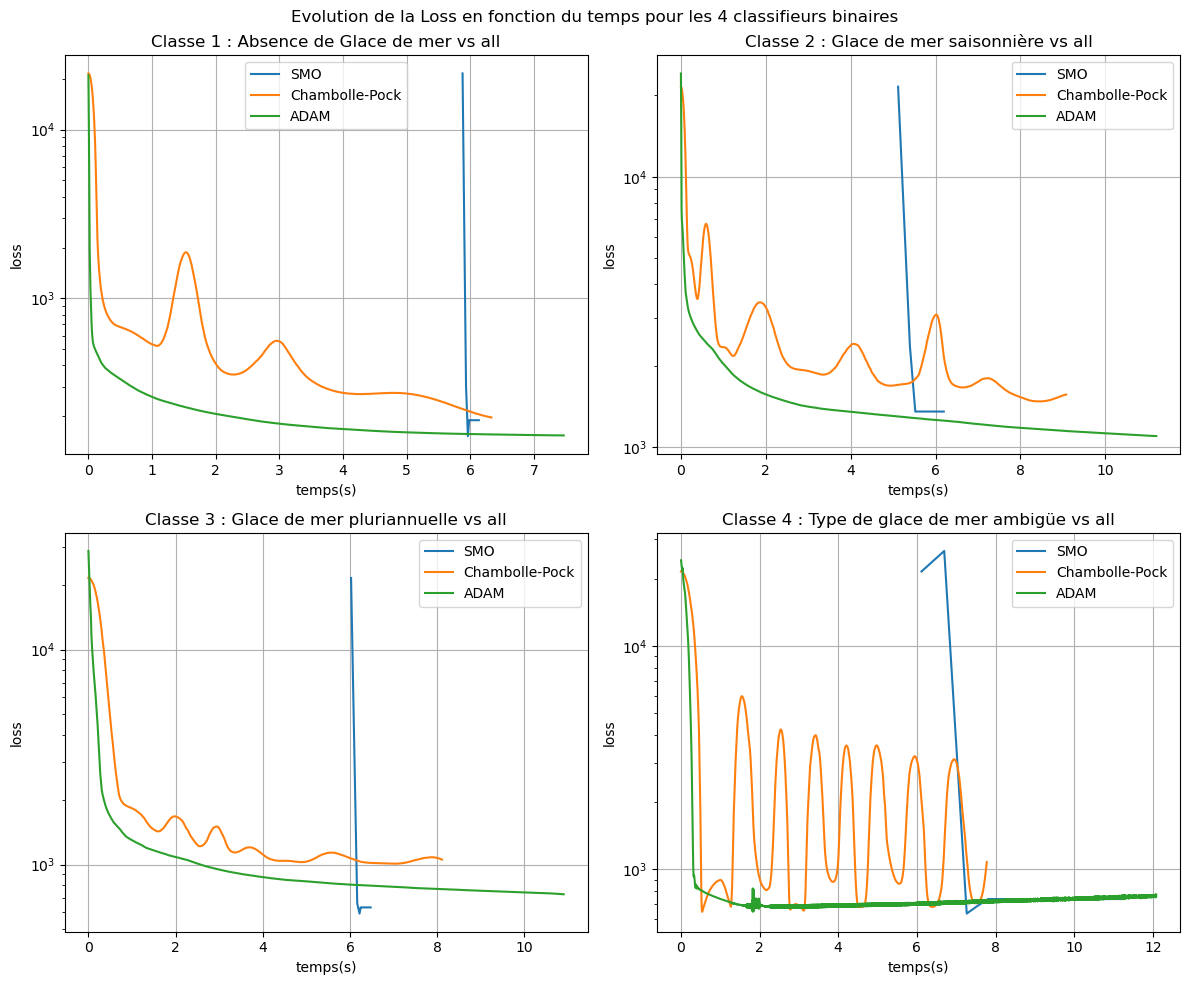

In [118]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))


axes[0, 0].plot(Tab_Loss_SMO[0][0], Tab_Loss_SMO[0][1], label = 'SMO')
axes[0, 0].plot(Tab_Loss_ChambollePock[0][0], Tab_Loss_ChambollePock[0][1], label = 'Chambolle-Pock')
axes[0, 0].plot(Tab_Loss_ADAM[0][0], Tab_Loss_ADAM[0][1], label = 'ADAM')
axes[0, 0].set_title("Classe 1 : Absence de Glace de mer vs all")
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].set_xlabel('temps(s)')
axes[0, 0].set_ylabel('loss') 
axes[0, 0].set_yscale('log')

axes[0, 1].plot(Tab_Loss_SMO[1][0], Tab_Loss_SMO[1][1], label = 'SMO')
axes[0, 1].plot(Tab_Loss_ChambollePock[1][0], Tab_Loss_ChambollePock[1][1], label = 'Chambolle-Pock')
axes[0, 1].plot(Tab_Loss_ADAM[1][0], Tab_Loss_ADAM[1][1], label = 'ADAM')
axes[0, 1].set_title("Classe 2 : Glace de mer saisonnière vs all")
axes[0, 1].grid(True)
axes[0, 1].legend()
axes[0, 1].set_xlabel('temps(s)')
axes[0, 1].set_ylabel('loss') 
axes[0, 1].set_yscale('log')

axes[1, 0].plot(Tab_Loss_SMO[2][0], Tab_Loss_SMO[2][1], label = 'SMO')
axes[1, 0].plot(Tab_Loss_ChambollePock[2][0], Tab_Loss_ChambollePock[2][1], label = 'Chambolle-Pock')
axes[1, 0].plot(Tab_Loss_ADAM[2][0], Tab_Loss_ADAM[2][1], label = 'ADAM')
axes[1, 0].set_title("Classe 3 : Glace de mer pluriannuelle vs all")
axes[1, 0].grid(True)
axes[1, 0].legend()
axes[1, 0].set_xlabel('temps(s)')
axes[1, 0].set_ylabel('loss') 
axes[1, 0].set_yscale('log')

axes[1, 1].plot(Tab_Loss_SMO[3][0], Tab_Loss_SMO[3][1], label = 'SMO')
axes[1, 1].plot(Tab_Loss_ChambollePock[3][0], Tab_Loss_ChambollePock[3][1], label = 'Chambolle-Pock')
axes[1, 1].plot(Tab_Loss_ADAM[3][0], Tab_Loss_ADAM[3][1], label = 'ADAM')
axes[1, 1].set_title("Classe 4 : Type de glace de mer ambigüe vs all")
axes[1, 1].grid(True)
axes[1, 1].legend()
axes[1, 1].set_xlabel('temps(s)')
axes[1, 1].set_ylabel('loss') 
axes[1, 1].set_yscale('log')

plt.suptitle('Evolution de la Loss en fonction du temps pour les 4 classifieurs binaires')
plt.tight_layout()
plt.show()

SMO, Chambolle-Pock et ADAM durent un temps similaire (autour de 10 secondes). SMO est meilleur que les 2 autres algorithmes d'un point de vue de la baisse de la loss. ADAM est meilleur que Chambolle-Pock pour le même critère.

La courbe de l'algorithme SMO débute à 6 secondes car c'est le temps qu'il faut au code pour calculer la Matrice de Gram, nécéssaire pour utiliser SMO. Une fois cette matrice calculée, SMO est très rapide < 2 secondes. 

### 4.2 Précision du classifieur

La fonction Multiclassifieur prends pour chaque donnée, les 4 scores du one-vs-all, et retourne en sortie la classe qui possède le score le plus élévé.

In [119]:
def Multiclassifieur(Tab_scores):
    
    #Prédiction de l'étiquette par la méthode 1 vs all
    Y_pred=np.argmax(Tab_scores, axis = 1) + 1
    
    return Y_pred

In [120]:
#Calcul des prédictions des classes pour les 3 jeux de données (train, test et tot)

Y_pred_train_SMO=Multiclassifieur(Tab_scores_train_SMO)
Y_pred_train_ChambollePock=Multiclassifieur(Tab_scores_train_ChambollePock)
Y_pred_train_ADAM=Multiclassifieur(Tab_scores_train_ADAM)

Y_pred_test_SMO=Multiclassifieur(Tab_scores_test_SMO)
Y_pred_test_ChambollePock=Multiclassifieur(Tab_scores_test_ChambollePock)
Y_pred_test_ADAM=Multiclassifieur(Tab_scores_test_ADAM)

Y_pred_tot_SMO=Multiclassifieur(Tab_scores_tot_SMO)
Y_pred_tot_ChambollePock=Multiclassifieur(Tab_scores_tot_ChambollePock)
Y_pred_tot_ADAM=Multiclassifieur(Tab_scores_tot_ADAM)

In [121]:
#Calcul de l'Accuracy (pourcentage de prédictions justes au total)

acc_train_SMO = np.mean(Y_pred_train_SMO == Y_train_original)
acc_test_SMO  = np.mean(Y_pred_test_SMO == Y_test)


acc_train_CP = np.mean(Y_pred_train_ChambollePock == Y_train_original)
acc_test_CP  = np.mean(Y_pred_test_ChambollePock == Y_test)


acc_train_ADAM = np.mean(Y_pred_train_ADAM == Y_train_original)
acc_test_ADAM  = np.mean(Y_pred_test_ADAM == Y_test)


data = {
    'SMO': [acc_train_SMO, acc_test_SMO],
    'Chambolle-Pock': [acc_train_CP, acc_test_CP],
    'ADAM': [acc_train_ADAM, acc_test_ADAM]
}

df_results = pd.DataFrame(data, index=['Train Accuracy', 'Test Accuracy'])

#Affichage
print("Pourcentage de prédictions justes :")
print(df_results.applymap(lambda x: f"{x:.2%}"))

Pourcentage de prédictions justes :
                   SMO Chambolle-Pock    ADAM
Train Accuracy  97.57%         97.19%  97.57%
Test Accuracy   97.55%         97.16%  97.33%


La prédiction des 3 algorithmes est très bonne (autour de 97.5%). SMO est légèrement meilleur que ADAM qui lui-même est légèrement meilleur que Chambolle-Pock. Ceci est vrai pour l'accuracy évaluée sur les données d'entrainement et sur les données test. 

Le fait que pour les 3 algorithmes l'accuracy pour les données de test soit proche de celui pour les données d'entraiement montre que les 3 algorithmes se génétalisent bien et que l'on n'est pas dans un cas de surraprentissage.

### 4.3 Matrices de confusion

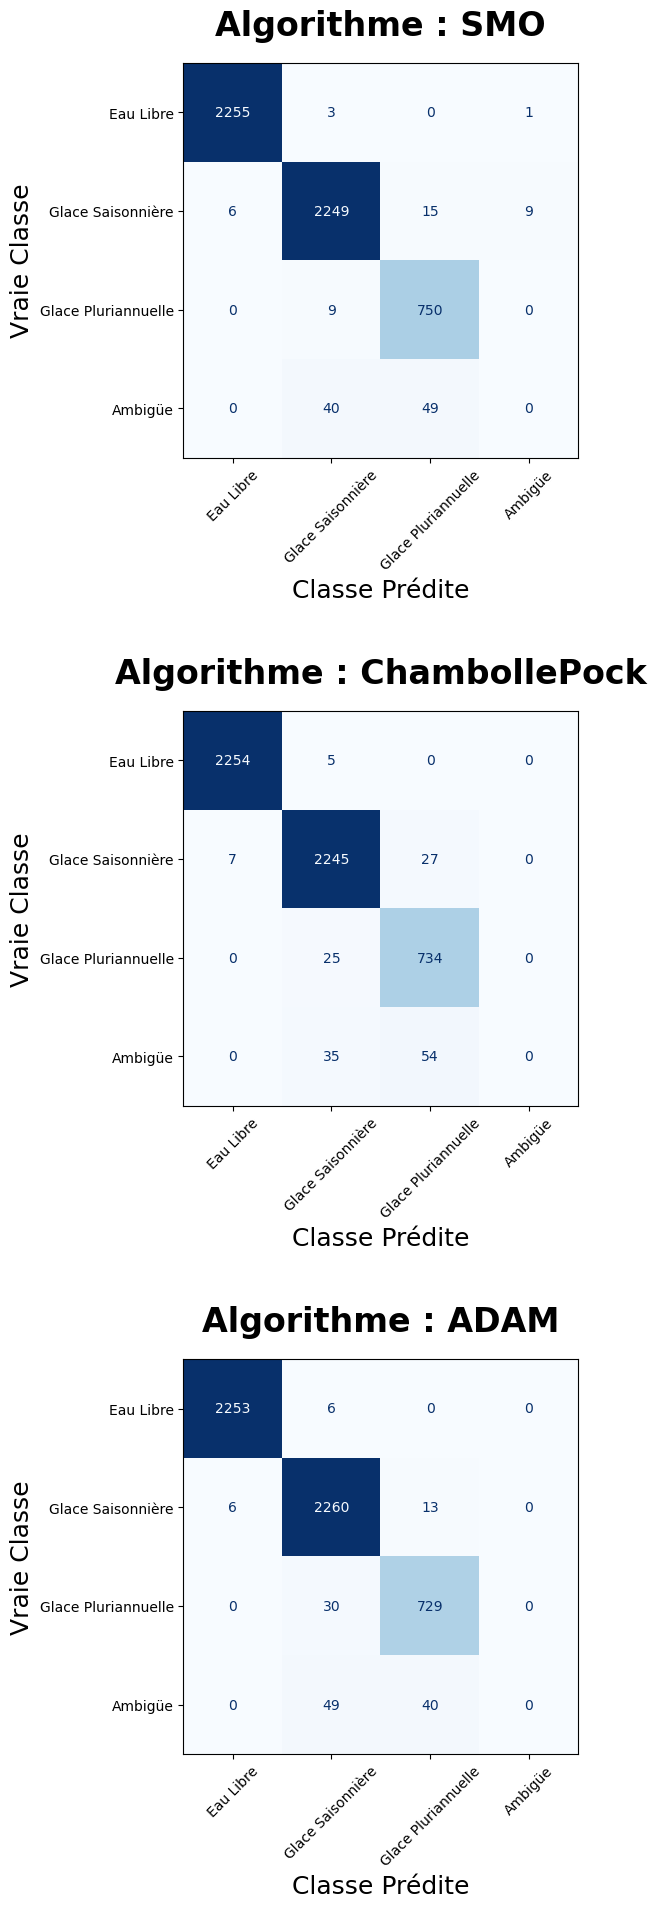

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

noms_classes = ['Eau Libre', 'Glace Saisonnière', 'Glace Pluriannuelle', 'Ambigüe']
modeles = [
    ("SMO", Y_pred_test_SMO),
    ("Chambolle-Pock", Y_pred_test_ChambollePock),
    ("ADAM", Y_pred_test_ADAM)
]

fig, axes = plt.subplots(3, 1, figsize=(10, 20))

cm_SMO = confusion_matrix(Y_test, Y_pred_test_SMO)
cm_ChambollePock = confusion_matrix(Y_test, Y_pred_test_ChambollePock)
cm_ADAM = confusion_matrix(Y_test, Y_pred_test_ADAM)
    
#Création des matrices de confusion
disp_SMO = ConfusionMatrixDisplay(confusion_matrix=cm_SMO, display_labels=noms_classes)
disp_ChambollePock = ConfusionMatrixDisplay(confusion_matrix=cm_ChambollePock, display_labels=noms_classes)
disp_ADAM = ConfusionMatrixDisplay(confusion_matrix=cm_ADAM, display_labels=noms_classes)
    
#Tracé des matrices de confusion
disp_SMO.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
disp_ChambollePock.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=False)
disp_ADAM.plot(ax=axes[2], cmap='Blues', values_format='d', colorbar=False)
    

axes[0].set_title(f"Algorithme : SMO", fontsize=24, fontweight='bold', pad=20)
axes[1].set_title(f"Algorithme : ChambollePock", fontsize=24, fontweight='bold', pad=20)
axes[2].set_title(f"Algorithme : ADAM", fontsize=24, fontweight='bold', pad=20)


for i in range(3):
    axes[i].tick_params(axis='x', rotation=45) 
    axes[i].set_xlabel('Classe Prédite', fontsize=18)
    axes[i].set_ylabel('Vraie Classe', fontsize=18)


plt.tight_layout(pad=4.0) 
plt.show()

plt.rcParams.update({'font.size': 10})

On remarque que les 2.5% d'erreur vu précédemment s'expliquent principalement par le fait que la classe 4 n'est jamais prédite par nos 3 algorithmes. Le deuxième facteur explicatif est la confusion entre Glace Saisonnière et Glace Pluriannuelle.

Malgré l'ajout d'un poids plus grand pour ces données dans le cas de l'algorithme ADAM, cela ne suffit pas. En essayant de réhausser ce poids, nous obtenons très rapidement une sureprésentation de la classe 4 dans les prédictions faites par l'algorithme ADAM.

## PARTIE 5 : Les résultats sur le problème considéré

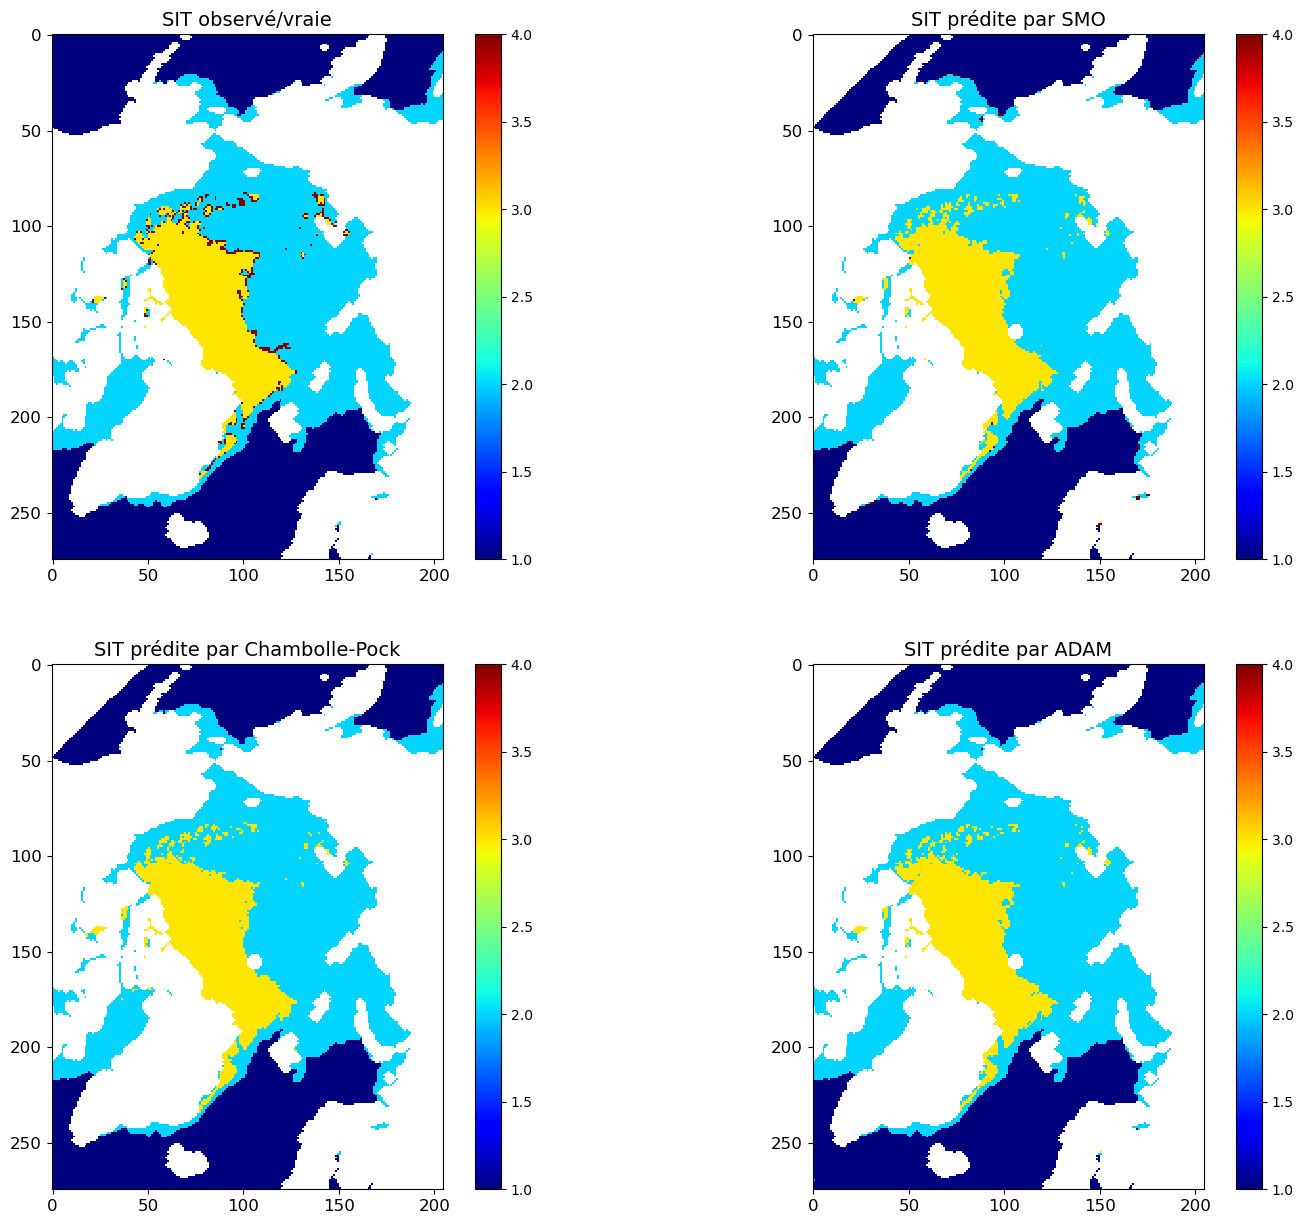

In [123]:
mask_new = (ds_original['sit'] > 0) * (ds_original['h06'] > 0)

sit_SMO = np.zeros_like(ds_original['sit'])
sit_SMO[:] = np.nan
sit_SMO[mask] = Y_pred_tot_SMO

sit_ChambollePock = np.zeros_like(ds_original['sit'])
sit_ChambollePock[:] = np.nan
sit_ChambollePock[mask] = Y_pred_tot_ChambollePock

sit_ADAM = np.zeros_like(ds_original['sit'])
sit_ADAM[:] = np.nan
sit_ADAM[mask] = Y_pred_tot_ADAM

fig, ax = plt.subplots(2,2, figsize=(18,15))
ax=ax.flatten()
ax[0].tick_params(labelsize=12)
ax[0].set_title('SIT observé/vraie' ,fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].set_title('SIT prédite par SMO',fontsize=14)
ax[2].tick_params(labelsize=12)
ax[2].set_title('SIT prédite par Chambolle-Pock',fontsize=14)
ax[3].tick_params(labelsize=12)
ax[3].set_title('SIT prédite par ADAM',fontsize=14)
img1=ax[0].imshow(ds_original['sit'], cmap='jet',interpolation='nearest')
plt.colorbar(img1)
img2=ax[1].imshow(sit_SMO, cmap='jet',interpolation='nearest', vmin=1, vmax=4)
plt.colorbar(img2)
img3=ax[2].imshow(sit_ChambollePock, cmap='jet',interpolation='nearest', vmin=1, vmax=4)
plt.colorbar(img3)
img4=ax[3].imshow(sit_ADAM, cmap='jet',interpolation='nearest', vmin=1, vmax=4)
plt.colorbar(img4)
plt.show()

On observe bien le fait que les 3 algorithmes donnent des résultats qui collent bien aux donnnées et le fait que la classe 4 (Glace dont l'état est ambigü) n'est quasiement jamais prédite par les 3 algorithmes.